# Harry Potter and Word2Vec

Word2vec is a method for embedding words into a small latent space which captures semantic meaning. The idea is to use a two layer (one hidden layer) fully connected neural network. The first layer of nodes (representing a one hot encoding of the index of some word $w$) connects to a small hidden layer which then connects to an output layer (representing a one hot encoding of the index of a word that appears near word $w$). Through training, we get the small hidden layer to hold the connection between words and their frequent neighbors.


In this demo, we'll implement word2vec using all seven Harry Potter books as our corpus.



## Libraries

As always, we rely on a lot of libraries.

In [ ]:
import pandas as pd
import re
import torch
import torch.nn as nn
import numpy as np
import matplotlib
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import urllib.request
import numpy
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

## Loading Text

We load the text of Harry Potter from a website and preprocess it. In particular, we only want the chapters of the book and we make all words lowercase. Finally, we remove annoying characters like new lines.

In [ ]:
url1 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%201%20-%20The%20Philosopher's%20Stone.txt"
url2 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%202%20-%20The%20Chamber%20of%20Secrets.txt"
url3 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt"
url4 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%204%20-%20The%20Goblet%20of%20Fire.txt"
url5 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt"
url6 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%206%20-%20The%20Half%20Blood%20Prince.txt"
url7 = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter/Book%207%20-%20The%20Deathly%20Hallows.txt"

def read_file(url, start_phrase, end_phrase, remove):
  with urllib.request.urlopen(url) as webpage:
    text = webpage.read().decode("utf8")
    start = text.index(start_phrase)
    text = text[start:]
    end = text.index(end_phrase)
    text = text[:end]
  return text.lower().replace('\n', '').replace('¬','').replace(',','').replace('.','').replace(remove, '')

text1 = read_file(url1, 'THE BOY WHO LIVED', 'Page | 348', 'Harry Potter and the Philosophers Stone - J.K. Rowling')
text2 = read_file(url2, 'THE WORST BIRTHDAY', 'Page | 380', 'Harry Potter and the Chamber of Secrets - J.K. Rowling')
text3 = read_file(url3, 'OWL POST', 'Page | 487', 'Harry Potter and the Prisoner of Azkaban - J.K. Rowling')
text4 = read_file(url4, 'THE RIDDLE HOUSE', 'Page | 811', 'Harry Potter and the Goblet of Fire - J.K. Rowling')
text5 = read_file(url5, 'DUDLEY DEMENTED', 'Page | 1108', 'Harry Potter and the Order of the Phoenix - J.K. Rowling')
text6 = read_file(url6, 'THE OTHER MINISTER', 'Page | 730', 'Harry Potter and the Half Blood Prince - J.K. Rowling')
text7 = read_file(url7, 'THE DARK LORD ASCENDING', 'Page | 856', 'Harry Potter and the Deathly Hallows - J.K. Rowling')

text = text1 + text2 + text3 + text4 + text5 + text6 + text7

In [ ]:
len(text)

6370219

## Tokenizing

Now we tokenize the text. That is, we turn the string into a list of words.

In [ ]:
def get_frequent(tokens, threshold=20):
  frequency = {token : 0 for token in set(tokens)} #build dictionary with key for every unique word
  for token in tokens:
    frequency[token] += 1 
  
  frequent_tokens = []
  for token in tokens: #iterate through text
    if frequency[token] >= threshold: 
      frequent_tokens += [token] 
  
  return frequent_tokens, len(set(frequent_tokens)) 

In [ ]:
letters = 'abcdefghijklmnopqrstuvwxyz' # pre-processing text
def process_word(word): #split based on based
  return ''.join([letter for letter in word if letter in letters]) #join letters
tokens = [process_word(word) for word in text.split(' ')]

tokens, num_tokens = get_frequent(tokens) #get each word as a value in a list
print(tokens[:100]) 

['the', 'boy', 'who', 'lived', 'mr', 'and', 'mrs', 'dursley', 'of', 'number', 'four', 'privet', 'drive', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', 'thank', 'you', 'very', 'much', 'they', 'were', 'the', 'last', 'people', 'youd', 'expect', 'to', 'be', 'involved', 'in', 'anything', 'strange', 'or', 'mysterious', 'because', 'they', 'just', 'didnt', 'hold', 'with', 'such', 'nonsense', 'mr', 'dursley', 'was', 'the', 'of', 'a', 'firm', 'called', 'which', 'made', 'he', 'was', 'a', 'big', 'man', 'with', 'hardly', 'any', 'neck', 'although', 'he', 'did', 'have', 'a', 'very', 'large', 'mustache', 'mrs', 'dursley', 'was', 'thin', 'and', 'blonde', 'and', 'had', 'nearly', 'twice', 'the', 'usual', 'amount', 'of', 'neck', 'which', 'came', 'in', 'very', 'useful', 'as', 'she', 'spent', 'so']


In [ ]:
num_tokens

3853

In [ ]:
print(f'There are {len(tokens)} total tokens and {num_tokens} unique tokens.')

There are 1093411 total tokens and 3853 unique tokens.


Now we map from each word (token) to a unique index and back. We will use this for the one hot encoding of the word.

In [ ]:
def mapping(tokens):
  word_to_id = {}
  id_to_word = {}

  for i, token in enumerate(set(tokens)): #creates correspondence between word and index
    word_to_id[token] = i
    id_to_word[i] = token
  
  return word_to_id, id_to_word

WORD_TO_ID, ID_TO_WORD = mapping(tokens) #global variable
num_tokens = len(set(tokens)) 
print(len(set(tokens)))

3853


The next step is to get the dataset we will use. We do this by iterating through the tokens with a sliding window. For each word $w$, we look at its neighbors $u$ and add a data point $(w,u)$ where we need to predict $u$ on input $w$. For now, we store the data as indices to avoid carrying around a bunch of zeros in the one hot encoding.

In [ ]:
def convert(x):
  return torch.tensor(np.asarray(x)).long()
  
def process(tokens, window=2, threshold=100): #window is proximity
  frequency = {WORD_TO_ID[token]: 0 for token in set(tokens)}
  X, y = [], [] #initialize two lists for 2-gram
  for i in range(len(tokens)-1):
    index_i = WORD_TO_ID[tokens[i]] 
    if frequency[index_i] < threshold: #if we have seen the word less than 100 times, then we process
      for j in list(range(max(0,i-window), min(len(tokens), i+window+1))): #range for tokens with window
        index_j = WORD_TO_ID[tokens[j]] #
        #if frequency[index_j] < threshold:
        X += [index_i] #add to lists
        y += [index_j]
        frequency[index_i] += 1 #update frequency
        frequency[index_j] += 1
  return X, y

# Initialization

Now we define the custom class we need so we can wrap the nice DataLoader function around our dataset.

In [ ]:
class DataSet(Dataset): #create dataset
  def __init__(self, tokens):
    X,y = process(tokens)
    self.X = X #initalize
    self.y = y
  
  def __len__(self): #length of list
    return len(self.X)
  
  def __getitem__(self, idx): #get a single item from dataset
    return self.X[idx], self.y[idx] 

dataloader = DataLoader(DataSet(tokens), batch_size = 128, shuffle=True) #128 words, random order

In [ ]:
class Word2Vec(nn.Module): #single matrix
  def __init__(self, num_tokens, embed_dim): #initialize with num_tokens and embedding dimensions which is the dim of matrix
    super(Word2Vec, self).__init__() #inherit from other class
    self.embedding = nn.Embedding(num_tokens, embed_dim) #takes number of tokens and embed dim to store fixed dicts
  
  def forward(self, x):
    return self.embedding(x) 


In [ ]:
def contrastive_loss(X_embedded, y_embedded):
  #positive examples
  #loss = 0
  #for x_embed, y_embed in zip(X_embedded, y_embedded):
    #loss += -1 * x_embed @ y_embed
  #negative examples
  #for i in range(len(X_embedded)):
    #x_embed = X_embedded[i]
    #j = np.random.choice(len(X_embedded))
    #while j == i:
     # j = np.random.choice(len(X_embedded)) 


  batch_size = len(X_embedded)
  gram = X_embedded @ y_embedded.T #embeddings multiplied by embeddings of another
  difference = gram - torch.eye(batch_size).to(DEVICE)
  return torch.sqrt(torch.square(difference).sum()/batch_size**2) #sqrt of square of differences, normalize by batchsize

Finally, we're ready to initialize the architecture, loss, and optimizer. Notice the simplicity of the model!

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embed_dim = 64

model = Word2Vec(num_tokens, embed_dim).to(DEVICE) #initialize model

losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #pass in all model parameters

## Training

Now let's train.

In [ ]:
num_epochs = 20

for epoch in range(1, num_epochs+1): #for each epoch
  total_loss = 0
  for (X,y) in dataloader: #for each batch in data loader
    X = X.to(DEVICE) #put data on device
    y = y.to(DEVICE)
    optimizer.zero_grad() #zero out gradient
    X_embedded = model(X)    #x embeddings
    y_embedded = model(y)    
    loss = contrastive_loss(X_embedded, y_embedded) #contrastive loss function
    loss.backward() #backward pass
    optimizer.step() #forward pass
    total_loss += loss.item() #update loss
  losses += [total_loss/len(dataloader)] #average loss
  print(f'Epoch: {epoch} \t Loss: {losses[-1]}') #print out epoch with loss


Epoch: 1 	 Loss: 5.636413382769142
Epoch: 2 	 Loss: 2.697772372509223
Epoch: 3 	 Loss: 1.3978812581466658
Epoch: 4 	 Loss: 0.7190174712358757
Epoch: 5 	 Loss: 0.3651240084360192
Epoch: 6 	 Loss: 0.19375832423216782
Epoch: 7 	 Loss: 0.12208216250325679
Epoch: 8 	 Loss: 0.09748822907883299
Epoch: 9 	 Loss: 0.08973436455782782
Epoch: 10 	 Loss: 0.08712913588614739
Epoch: 11 	 Loss: 0.08602561397394225
Epoch: 12 	 Loss: 0.08549976010011145
Epoch: 13 	 Loss: 0.08520963887905411
Epoch: 14 	 Loss: 0.08506949697431711
Epoch: 15 	 Loss: 0.08499063575357135
Epoch: 16 	 Loss: 0.08495324043760463
Epoch: 17 	 Loss: 0.08492078033836291
Epoch: 18 	 Loss: 0.08490470498481195
Epoch: 19 	 Loss: 0.08489194733172464
Epoch: 20 	 Loss: 0.0848826408450047


## Exploring the Embeddings

What is the next word predicted?

In [ ]:
target = torch.tensor([WORD_TO_ID['quidditch']]).to(DEVICE)
candidates = torch.tensor(list(ID_TO_WORD.keys())).to(DEVICE) #all different IDs and put on device so runs quickly
candidates_embedded = model(candidates) #apply model
target_embedded = model(target) 

similarities = candidates_embedded @ target_embedded.T #compute similarities between two
_, indices = torch.topk(similarities.squeeze(), 10) #

for index in indices:
  print(ID_TO_WORD[index.item()]) #convert ID back to word and print out

#print out all words similar to quidditch

pitch
seeker
quidditch
teams
captain
chess
played
game
chasers
winning


To investigate the model, let's visualize the embeddings of the words.

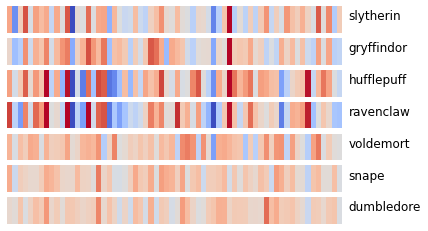

In [ ]:
def embed(word):
  return model(torch.tensor(WORD_TO_ID[word]).to(DEVICE)).detach().cpu().numpy()

words = ['slytherin', 'gryffindor', 'hufflepuff', 'ravenclaw',
         'voldemort', 'snape', 'dumbledore']
embeddings = [embed(word) for word in words] 
num_embed = len(embeddings)
cmap = matplotlib.cm.coolwarm
fig, axes = plt.subplots(num_embed, 1)
norm = matplotlib.colors.Normalize(vmin=embeddings[0].min(), vmax=embeddings[0].max())
for idx in range(num_embed):
  ax = axes[idx]
  embedding = embeddings[idx]
  for i in range(embed_dim):
    ax.add_patch(Rectangle((i/embed_dim, 0),.05,1, color=cmap(norm(embedding[i]))))
  ax.text(1.02, .5, words[idx], fontsize=12)
  ax.axis('off')
plt.show()